# Libs, Dataset and helphul things

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import torch # using PyTorch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as Funk

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio # to play audio
from IPython.display import clear_output

from tqdm import tqdm
from pathlib import Path

2.1.2
2.1.2


In [2]:
wf, sr = torchaudio.load('/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_1.wav')

In [3]:
os.makedirs('/kaggle/working/graphs')

In [4]:
def plot_spectrogram(waveform, sample_rate=4000, title=None, ylabel="freq_bin", ax=None):
    n_fft = 1024
    #         win_length = None
    #         hop_length = 512
    n_mels = 224
    
#     print(waveform, waveform.shape)
    
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
    #     win_length=win_length,
    #     hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
        norm="slaney",
        n_mels=n_mels,
        mel_scale="htk",
    )
    
    x = mel_spectrogram(torch.tensor(waveform[0]))
    mlspc = librosa.power_to_db(x)

    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(mlspc, origin="lower", aspect="auto", interpolation="nearest")

In [5]:
def plot_waveform(waveform, sample_rate=4000, title=None, xlim=None, ylim=None, ax=None):
#     waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

#     figure, axes = plt.subplots(num_channels, 1)

    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
        
        
    ax.plot(time_axis, waveform[0], linewidth=1)

In [6]:
waveform, sample_rate = torchaudio.load('/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_1.wav')

In [7]:
waveform = waveform[0][:5].numpy()
waveform = torch.Tensor([waveform])
waveform

/tmp/ipykernel_25/2964487695.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  waveform = torch.Tensor([waveform])


tensor([[ 0.0038,  0.0033,  0.0002, -0.0007, -0.0020]])

In [8]:
class AudioDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        sound = torchaudio.load(file)
        return sound

    def __getitem__(self, index):        

        waveform, sample_rate = self.load_sample(self.files[index])
        resample_rate = 4000
        
        wave_shape = waveform.shape[1]
        if wave_shape < 160768:
            waveform = torch.cat((waveform, torch.zeros(1, 160768-wave_shape)), 1)
            
#         if wave_shape > 115219:
#             waveform = waveform[0][:115219].numpy()
#             waveform = torch.Tensor([waveform])
        
        resampled_waveform = Funk.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
        

        return resampled_waveform

In [9]:
train_dir = Path('/kaggle/input/vgg-sound-only-cat-and-dog-sounds/audio_train')
val_dir = Path('/kaggle/input/vgg-sound-only-cat-and-dog-sounds/audio_test')

train_data = sorted(list(train_dir.rglob('*wav')))
val_data = sorted(list(val_dir.rglob('*wav')))

train_dataset = AudioDataset(train_data, mode='train')
val_dataset = AudioDataset(val_data, mode='val')

In [10]:
# max_waveform = 0
# waveforms = []
# for file in train_data:
#     waveform, sample_rate = torchaudio.load(file)
#     candidate = waveform.shape[1]
#     waveforms.append(waveform)
#     if candidate > max_waveform:
#         max_waveform = candidate

In [11]:
# lens = []
# for form in waveforms:
#     lens.append(form[0].numpy().shape[0])

In [12]:
# max(lens), min(lens), np.mean(lens), np.median(lens)

In [13]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for DATA in val_dataloader:
        work_data = DATA
        break

In [15]:
waveform, sample_rate = torchaudio.load('/kaggle/input/audio-cats-and-dogs/cats_dogs/test/cats/cat_110.wav')
resample_rate = 4000
resampled_waveform = Funk.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)

In [16]:
waveform.shape, resampled_waveform.shape

(torch.Size([1, 20352]), torch.Size([1, 5088]))

In [17]:
for data in train_dataloader:
    print(data.shape)
    break

torch.Size([16, 1, 40192])


# VQ-VAE
I took (and adapted) some code from [here](https://www.kaggle.com/code/maunish/training-vq-vae-on-imagenet-pytorch) and [there](https://www.kaggle.com/code/tenffe/vq-vae2-0-for-dog-image-generation), btw these are great notebooks :)

In [18]:
def vq_loss(inputs, embedded, commitment=0.25):
        """
        Compute the codebook and commitment losses for an
        input-output pair from a VQ layer.
        """
        return (torch.mean(torch.pow(inputs.detach() - embedded, 2)) +
                commitment * torch.mean(torch.pow(inputs - embedded.detach(), 2)))

class VQ(nn.Module):
    
    def __init__(self,num_embeddings=2048,embedding_dim=128,commitment_cost=0.25,dead_rate=100):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        
#         self.embeddings = nn.Embedding(self.num_embeddings,self.embedding_dim)
#         self.embeddings.weight.data.uniform_(-1/self.num_embeddings,1/self.num_embeddings)
        
        self.dead_rate = dead_rate
        self.dictionary = nn.Parameter(torch.randn(num_embeddings, embedding_dim))
        self.usage_count = nn.Parameter(dead_rate * torch.ones(num_embeddings).long(),
                                        requires_grad=False)
        self._last_batch = None
    
    def embed(self, idxs):
        """
        Convert encoded indices into embeddings.
        Args:
            idxs: an [N x H x W] or [N] Tensor.
        Returns:
            An [N x H x W x C] or [N x C] Tensor.
        """
        embedded = F.embedding(idxs, self.dictionary)
#         if len(embedded.shape) == 4:
#             # NHWC to NCHW
#             embedded = embedded.permute(0, 3, 1, 2).contiguous()
#         elif len(embedded.shape) == 3:
#             # NHWC to NCHW
#             embedded = embedded.permute(0, 2, 1).contiguous()
        return embedded
    
    def forward(self,inputs):
        channels_last = inputs.permute(0, 2, 1).contiguous()
        
        inputs_shape = channels_last.shape
        flat_input = channels_last.view(-1,self.embedding_dim)
        
#         diffs = embedding_distances(self.dictionary, channels_last)
#         print(self.dictionary.shape, channels_last.shape)

        distances = torch.cdist(self.dictionary, flat_input)
        
#         print(self.dictionary.shape, flat_input.shape, distances.shape)
    
        indexes = torch.argmin(distances, dim=0)
        
#         print(inputs.shape, indexes.shape, self.embed(indexes).shape, channels_last.shape)
        
        embedded = self.embed(indexes).view(inputs_shape).permute(0, 2, 1).contiguous()
        embedded_pt = embedded.detach() + (inputs - inputs.detach())

        quanti_loss = vq_loss(inputs, embedded) 
        
        if self.training:
            self._update_tracker(indexes)
            self._last_batch = channels_last.detach()

        return quanti_loss, embedded_pt
    
    def revive_dead_entries(self, inputs=None):
        """
        Use the dictionary usage tracker to re-initialize
        entries that aren't being used often.
        Args:
          inputs: a batch of inputs from which random
            values are sampled for new entries. If None,
            the previous input to forward() is used.
        """
        if inputs is None:
            assert self._last_batch is not None, ('cannot revive dead entries until a batch has ' +
                                                  'been run')
            inputs = self._last_batch
        counts = self.usage_count.detach().cpu().numpy()
        new_dictionary = None
        inputs_numpy = None
        for i, count in enumerate(counts):
            if count:
                continue
            if new_dictionary is None:
                new_dictionary = self.dictionary.detach().cpu().numpy()
            if inputs_numpy is None:
                inputs_numpy = inputs.detach().cpu().numpy().reshape([-1, inputs.shape[-1]])
            new_dictionary[i] = random.choice(inputs_numpy)
            counts[i] = self.dead_rate
        if new_dictionary is not None:
            dict_tensor = torch.from_numpy(new_dictionary).to(self.dictionary.device)
            counts_tensor = torch.from_numpy(counts).to(self.usage_count.device)
            self.dictionary.data.copy_(dict_tensor)
            self.usage_count.data.copy_(counts_tensor)

    def _update_tracker(self, idxs):
        raw_idxs = set(idxs.detach().cpu().numpy().flatten())
        update = -np.ones([self.num_embeddings], dtype=int)
        for idx in raw_idxs:
            update[idx] = self.dead_rate
        self.usage_count.data.add_(torch.from_numpy(update).to(self.usage_count.device).long())
        self.usage_count.data.clamp_(0, self.dead_rate)
    
def embedding_distances(dictionary, tensor):
    """
    Compute distances between every embedding in a
    dictionary and every vector in a Tensor.
    This will not generate a huge intermediate Tensor,
    unlike the naive implementation.
    Args:
        dictionary: a [D x C] Tensor.
        tensor: a [... x C] Tensor.
    Returns:
        A [... x D] Tensor of distances.
    """
    dict_norms = torch.sum(torch.pow(dictionary, 2), dim=-1)
    tensor_norms = torch.sum(torch.pow(tensor, 2), dim=-1)

    # Work-around for https://github.com/pytorch/pytorch/issues/18862.
    exp_tensor = tensor[..., None].view(-1, tensor.shape[-1], 1)
    exp_tensor = exp_tensor.unsqueeze(1)
    
    exp_dict = dictionary[None].expand(exp_tensor.shape[0], *dictionary.shape)
    dots = torch.matmul(exp_dict, exp_tensor)[..., 0]
    dots = dots.view(*tensor.shape[:-1], dots.shape[-1])

    return -2 * dots + dict_norms + tensor_norms[..., None]

In [19]:
class ResBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels,pad=1,dilate=1):
        super(ResBlock,self).__init__()
        self.resblock = nn.Sequential( nn.ReLU(inplace=True),
                                       nn.Conv1d(in_channels,hidden_channels,kernel_size=3,stride=1,padding=pad,dilation=dilate, bias=False),
#                                        nn.BatchNorm2d(hidden_channels),
                                       nn.ReLU(inplace=True),
                                       nn.Conv1d(hidden_channels,out_channels,kernel_size=1,stride=1,bias=False),)
#                                        nn.BatchNorm2d(out_channels))
    def forward(self,x):
        return x + self.resblock(x)

class ResNet(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels,num_res_layers=1):
        super(ResNet,self).__init__()
        self.num_res_layers = num_res_layers
        self.layers = nn.ModuleList([
            ResBlock(in_channels,out_channels,hidden_channels),
            ResBlock(in_channels,out_channels,hidden_channels,pad=2,dilate=2),
            ResBlock(in_channels,out_channels,hidden_channels,pad=3,dilate=3),
            ResBlock(in_channels,out_channels,hidden_channels,pad=6,dilate=6),
            ResBlock(in_channels,out_channels,hidden_channels,pad=9,dilate=9),
            ResBlock(in_channels,out_channels,hidden_channels,pad=18,dilate=18),
            ResBlock(in_channels,out_channels,hidden_channels,pad=27,dilate=27)
        ])
    
    def forward(self,x):
        for i in range(self.num_res_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [20]:
class vq_vae_2(nn.Module):

    def __init__(self,num_embeddings=2048,embedding_dim=128,commitment_cost=0.25):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.dec_bot_in = int(embedding_dim + embedding_dim / 4)
        
#         self.rec_criterion = nn.BCELoss(reduction='sum')
        self.rec_criterion = nn.MSELoss(reduction='sum')
    
        #encode
        self.enc_bottom = nn.Sequential(
            nn.Conv1d(1,32,kernel_size=3,stride=2,padding=1), # 224x315 > 112x158 
            ResNet(32,32,32),
            
            nn.Conv1d(32,32,kernel_size=3,stride=2,padding=1), # 112x158  > 56x79
            ResNet(32,32,32),
            
            nn.Conv1d(32,32,kernel_size=3,stride=2,padding=1), # 56x79 > 28x40
            ResNet(32,32,32),
            
            nn.Conv1d(32,128,kernel_size=3,stride=1,padding=1)
        )
        
        #vq 
#         self.vq_conv_bottom = nn.Conv2d(256,self.embedding_dim,kernel_size=1,stride=1)
#         self.vq_bottom = VQ(self.num_embeddings,self.embedding_dim,self.commitment_cost)
        
        self.enc_top = nn.Sequential(
            nn.Conv1d(128,32,kernel_size=3,stride=2,padding=1), # 28x40 > 14x20
            ResNet(32,32,32),
            
            nn.Conv1d(32,32,kernel_size=3,stride=2,padding=1), # 14x20  > 7x10
            ResNet(32,32,32),
            
            nn.Conv1d(32,128,kernel_size=3,stride=1,padding=1)
        )
        
        self.vq_conv_top = nn.Conv1d(128,self.embedding_dim,kernel_size=1,stride=1)
        self.vq_top = VQ(self.num_embeddings,self.embedding_dim,self.commitment_cost)
        
        self.dec_top = nn.Sequential(
            nn.Conv1d(self.embedding_dim,32,kernel_size=3,stride=1,padding=0),
            ResNet(32,32,32),
            
            nn.ConvTranspose1d(32,32,kernel_size=4,stride=2,padding=0, output_padding=1),
            ResNet(32,32,32),
            
            nn.ConvTranspose1d(32,128,kernel_size=4,stride=2,padding=0),
        )
        
        self.vq_conv_bottom = nn.Conv1d(256,self.embedding_dim,kernel_size=1,stride=1)
        self.vq_bottom = VQ(self.num_embeddings,self.embedding_dim,self.commitment_cost)
        
        #decode
        self.dec_bottom = nn.Sequential(
            nn.ConvTranspose1d(256,32,kernel_size=1,stride=1,padding=0),
            ResNet(32,32,32),
            
            nn.ConvTranspose1d(32,32,kernel_size=4,stride=2,padding=1),
            ResNet(32,32,32),
            
            nn.ConvTranspose1d(32,32,kernel_size=4,stride=2,padding=1),
            ResNet(32,32,32),
            
            nn.ConvTranspose1d(32,1,kernel_size=4,stride=2,padding=1),
            # 112x158 > 224x315
        )
        
        self.vq_upsampler = nn.Sequential(
            nn.ConvTranspose1d(self.embedding_dim,64,kernel_size=4,stride=2, padding=1),
            ResNet(64,64,64),
            
            nn.ConvTranspose1d(64,64,kernel_size=4,stride=2,padding=1),
            ResNet(64,64,64),
            nn.Conv1d(64,128,kernel_size=3,stride=1,padding=1),
        )

    def encode(self,x):
        enc_bot = self.enc_bottom(x)
        enc_top = self.enc_top(enc_bot)
        
        c_loss_top, vq_t = self.vq_top(self.vq_conv_top(enc_top))
        dec_top = self.dec_top(vq_t)
    
        concatenated = torch.cat((enc_bot, dec_top), 1)
        c_loss_bot, vq_b = self.vq_bottom(self.vq_conv_bottom(concatenated))
        
        return vq_b, vq_t
        
    def decode(self,q_top, q_bot):
        q_up_top = self.vq_upsampler(q_top)
        concat = torch.cat((q_bot, q_up_top), 1)
        
        x = self.dec_bottom(concat)
        return x
    
    def revive_dead_entries(self):
        """
        Revive dead entries from all of the VQ layers.
        Only call this once the encoders have all been
        through a forward pass in training mode.
        """
        for vq in [self.vq_top, self.vq_bottom]:
            vq.revive_dead_entries()
    
    

    def forward(self,inputs):
        enc_bot = self.enc_bottom(inputs)
        enc_top = self.enc_top(enc_bot)
        
#         print(enc_top.shape)
        
        c_loss_top, vq_top = self.vq_top(self.vq_conv_top(enc_top))
        dec_top = self.dec_top(vq_top)
        
#         print(torch.max(enc_bot), torch.max(dec_top))
#         print(torch.min(enc_bot), torch.min(dec_top))
        
        rec_loss_top = self.rec_criterion(enc_bot,dec_top)
        
        concatenated = torch.cat((enc_bot, dec_top), 1)
#         print(concatenated.shape)
        c_loss_bot, vq_bot = self.vq_bottom(self.vq_conv_bottom(concatenated))
        
#         c_loss_bot_1, vq_bot_1 = self.vq_bottom(enc_bot)
#         c_loss_bot_2, vq_bot_2 = self.vq_bottom(dec_top)
        
#         vq_bot = torch.cat((vq_bot_1, vq_bot_2), 1)
#         c_loss_bot = c_loss_bot_1 + c_loss_bot_2
#         print(vq_top.shape)
        vq_upsampled_top = self.vq_upsampler(vq_top)
        concatenated_vq = torch.cat((vq_bot, vq_upsampled_top), 1)
        outputs = self.dec_bottom(concatenated_vq)
        
        rec_loss_full = self.rec_criterion(outputs,inputs)
        
        c_loss = c_loss_top + c_loss_bot
        rec_loss = rec_loss_top + rec_loss_full
        loss = rec_loss + c_loss
        
        return outputs,loss, c_loss_top,c_loss_bot,rec_loss_top,rec_loss_full

# Training

In [21]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
is_cuda = (device == torch.device('cuda'))

In [22]:
def train(model, opt, sched, epoch_start, epochs, data_tr, data_val):
    losses_tr = {
        'q_bot': [],
        'q_top': [],
        'rec_top': [],
        'rec_full': [],
        'total': [],
    }
    losses_val = {
        'q_bot': [],
        'q_top': [],
        'rec_top': [],
        'rec_full': [],
        'total': [],
    }
    
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epoch_start, epoch_start + epochs):
            
            if epoch % 15 == 0:
                torch.save(model.state_dict(), 'VQ-VAE-2-cat-dog-smallds-epoch-'+str(epoch)+'.pt')
                torch.save(optimizer.state_dict(), 'VQ-VAE-2-cat-dog-smallds-epoch-'+str(epoch)+'-ADAM.pt')
            
            
            if is_cuda:
                torch.cuda.empty_cache()
            gc.collect()

            model.train()
            
            train_q_bot = 0
            train_q_top = 0
            train_rec_top = 0
            train_rec_full = 0
            train_total = 0
            
            for Data_real in data_tr:
                Data_real = Data_real.to(device) #.permute(0, 3, 1, 2)

                opt.zero_grad()

                _,loss,q_loss_top,q_loss_bot,rec_loss_top,rec_loss_full = model(Data_real)
                #print(Data_rec.shape, Data_real.shape)
                loss.backward()
                opt.step()
                model.revive_dead_entries()
                
                sched.step()
                
                train_q_bot += q_loss_bot.mean()
                train_q_top += q_loss_top.mean()
                train_rec_top += rec_loss_top.mean()
                train_rec_full += rec_loss_full.mean()
                train_total += loss.mean()
                
                del Data_real
                if is_cuda:
                    torch.cuda.empty_cache()
                gc.collect()

            losses_tr['q_bot'].append(train_q_bot.detach().cpu())
            losses_tr['q_top'].append(train_q_top.detach().cpu())
            losses_tr['rec_top'].append(train_rec_top.detach().cpu())
            losses_tr['rec_full'].append(train_rec_full.detach().cpu())
            losses_tr['total'].append(train_total.detach().cpu())

            model.eval()

            with torch.no_grad():
                
                val_q_bot = 0
                val_q_top = 0
                val_rec_top = 0
                val_rec_full = 0
                val_total = 0
                
                for data_real in data_val:
                    data_real = data_real.to(device) #clamp

                    _,loss,q_loss_top,q_loss_bot,rec_loss_top,rec_loss_full = model(data_real) #.permute(0, 3, 1, 2)

                    val_q_bot += q_loss_bot.mean()
                    val_q_top += q_loss_top.mean()
                    val_rec_top += rec_loss_top.mean()
                    val_rec_full += rec_loss_full.mean()
                    val_total += loss.mean()
                    
                    if is_cuda:
                        torch.cuda.empty_cache()
                    gc.collect()

            
            losses_val['q_bot'].append(val_q_bot.detach().cpu())
            losses_val['q_top'].append(val_q_top.detach().cpu())
            losses_val['rec_top'].append(val_rec_top.detach().cpu())
            losses_val['rec_full'].append(val_rec_full.detach().cpu())
            losses_val['total'].append(val_total.detach().cpu())

            if is_cuda:
                torch.cuda.empty_cache()
            gc.collect()

            with torch.no_grad():
                y_demo, _, _, _, _, _ = model(data_real.to(device)) #permute(0, 3, 1, 2)
                y_demo = y_demo.detach().cpu()
                

            clear_output(wait=True)
            fig, ax = plt.subplots(2, 3, figsize=(10,6))
            
            for i in range(3):
                plot_waveform(data_real[i].cpu().numpy(), ax=ax[0, i])
                ax[0, i].grid(visible=True)
                ax[0, i].set_title('Real '+str(i))
#                 ax[0, i].axis('off')

                plot_waveform(y_demo[i].cpu().numpy(), ax=ax[1, i])
                ax[1, i].grid(visible=True)
                ax[1, i].set_title('Reconstructed '+str(i))
#                 ax[1, i].axis('off')

                plt.tight_layout()
                plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_total))

            plt.tight_layout()

            fig2, ax2 = plt.subplots(2, 2, figsize=(10,6))
            ax2[0, 0].plot(losses_tr['rec_full'], label='train')
            ax2[0, 1].plot(losses_tr['rec_top'], label='train')
            ax2[0, 0].plot(losses_val['rec_full'], label='val')
            ax2[0, 1].plot(losses_val['rec_top'], label='val')
            
            ax2[0, 0].set_yscale('log')
            ax2[0, 0].set_title('Reconstruction loss (full)')
            ax2[0, 1].set_yscale('log')
            ax2[0, 1].set_title('Reconstruction loss (top)')
            
            ax2[1, 0].plot(losses_tr['q_bot'], label='train')
            ax2[1, 1].plot(losses_tr['q_top'], label='train')
            ax2[1, 0].plot(losses_val['q_bot'], label='val')
            ax2[1, 1].plot(losses_val['q_top'], label='val')
            
            ax2[1, 0].set_yscale('log')
            ax2[1, 0].set_title('Quantization loss (bot)')
            ax2[1, 1].set_yscale('log')
            ax2[1, 1].set_title('Quantization loss (top)')

            plt.tight_layout()
            plt.legend()
            plt.show()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_total,\
                                           v_loss=val_total))
            if epoch % 3 == 0:
                fig.savefig(f'/kaggle/working/graphs/comparasion {epoch}.jpg')
    fig.savefig('comparasion.jpg')
    fig2.savefig('losses.jpg')
    return losses_tr, losses_val

In [23]:
for data in train_dataloader:
    print(data.shape)
    break

torch.Size([16, 1, 40192])


In [24]:
epoch_steps = train_dataset.__len__()
epoch_steps

5099

In [25]:
model = vq_vae_2().to(device)
# model.load_state_dict(torch.load('/kaggle/input/vq-vae-catdog/pytorch/residual-v1/4/VQ-VAE-2-cat-dog-smallds-v2.pt'))
print('deviced')

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# ADAM_state_dict = torch.load('/kaggle/input/vq-vae-catdog/pytorch/residual-v1/4/VQ-VAE-2-cat-dog-smallds-v2-ADAM.pt')
# ADAM_state_dict['param_groups'][0]['lr'] = 2e-5 # learning rate decay... at least, kind of it
# optimizer.load_state_dict(ADAM_state_dict)

deviced


Basically, I trained different versions different amounts of time, and in this particular version of notebook I load some state_dict from previous training. But the code will work from ground up, if you need it :)

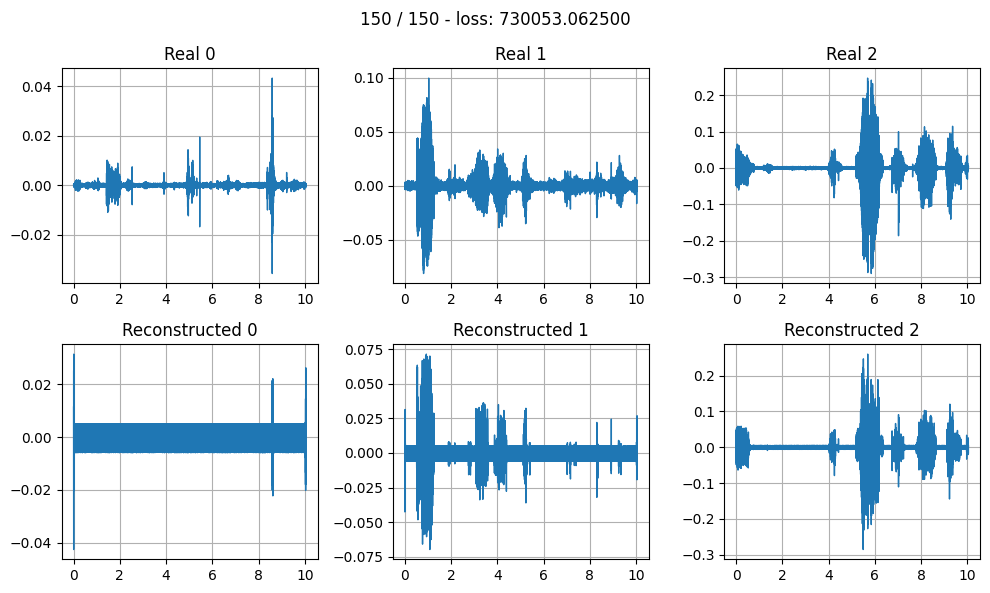

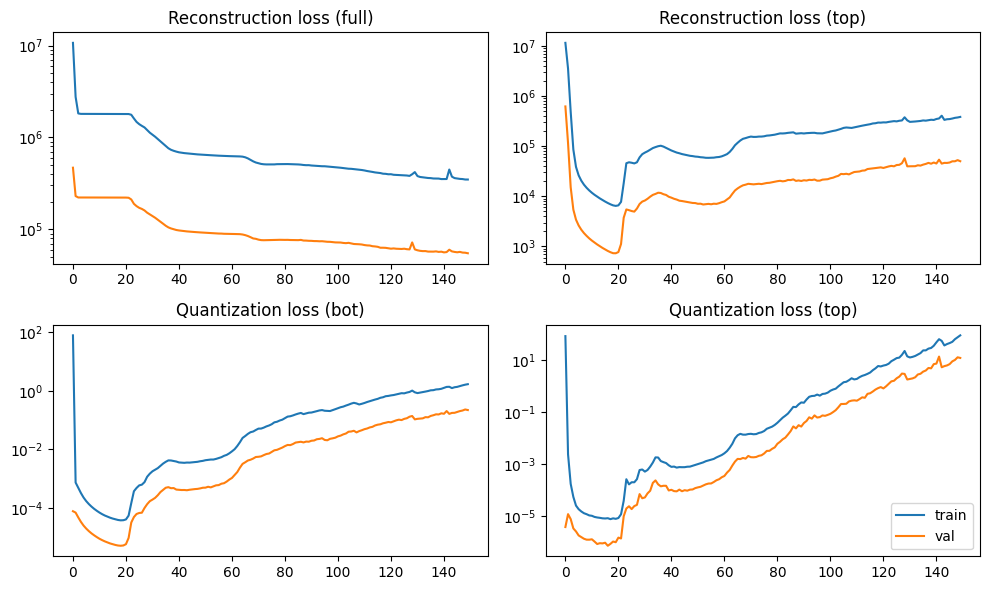

epoch: 100%|██████████| 150/150 [8:08:16<00:00, 195.31s/it]



Epoch 150 train_loss: 730053.0625     val_loss 104929.9062


In [26]:
epoch_start = 0
max_epoch = 150
epoch_total = max_epoch - epoch_start

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=epoch_steps, epochs=epoch_total)
history = train(model, optimizer, scheduler, epoch_start, max_epoch, train_dataloader, val_dataloader)

In [27]:
torch.save(model.state_dict(), 'VQ-VAE-2-cat-dog-smallds-raw-v2.pt')
torch.save(optimizer.state_dict(), 'VQ-VAE-2-cat-dog-smallds-raw-v2-ADAM.pt')

In [28]:
# def specplotterresearch2000(file, ax=None):
#     waveform, sample_rate = torchaudio.load(file)
#     wave_shape = waveform.shape[1]
#     if wave_shape < 283008:
#         waveform = torch.cat((waveform, torch.zeros(1, 283008-wave_shape)), 1)

#     if wave_shape > 283008:
#         waveform = waveform[0][:283008].numpy()
#         waveform = torch.Tensor([waveform])

#     n_fft = 1024
#     #         win_length = None
#     #         hop_length = 512
#     n_mels = 224

#     mel_spectrogram = T.MelSpectrogram(
#         sample_rate=sample_rate,
#         n_fft=n_fft,
#     #     win_length=win_length,
#     #     hop_length=hop_length,
#         center=True,
#         pad_mode="reflect",
#         power=2.0,
#         normalized=True,
#         norm="slaney",
#         n_mels=n_mels,
#         mel_scale="htk",
#     )

#     x = mel_spectrogram(waveform)
#     mlspc = librosa.power_to_db(x)

#     plot_spectrogram(mlspc[0], ax=ax)

In [29]:
# cat_examples = ['/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_116.wav', '/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_118.wav', '/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_109.wav']
# dog_examples = ['/kaggle/input/audio-cats-and-dogs/cats_dogs/train/dog/dog_barking_1.wav', '/kaggle/input/audio-cats-and-dogs/cats_dogs/train/dog/dog_barking_11.wav', '/kaggle/input/audio-cats-and-dogs/cats_dogs/train/dog/dog_barking_110.wav']

In [30]:
# fig, ax = plt.subplots(2, 3, figsize=(10,6))
            
# for i in range(3):
#     specplotterresearch2000(cat_examples[i], ax=ax[0, i])
#     ax[0, i].set_title('Cat '+str(i))
#     ax[0, i].axis('off')

#     specplotterresearch2000(dog_examples[i], ax=ax[1, i])
#     ax[1, i].set_title('Dog '+str(i))
#     ax[1, i].axis('off')

#     plt.tight_layout()

# Exploring Results

In [31]:
model.eval()
with torch.no_grad():
    for DATA in val_dataloader:
        work_data = DATA.to(device)
        break

In [32]:
# prev_history = history

In [33]:
reconstructions, _, _, _, _, _, = model(work_data)
reconstructions.shape

torch.Size([16, 1, 40192])

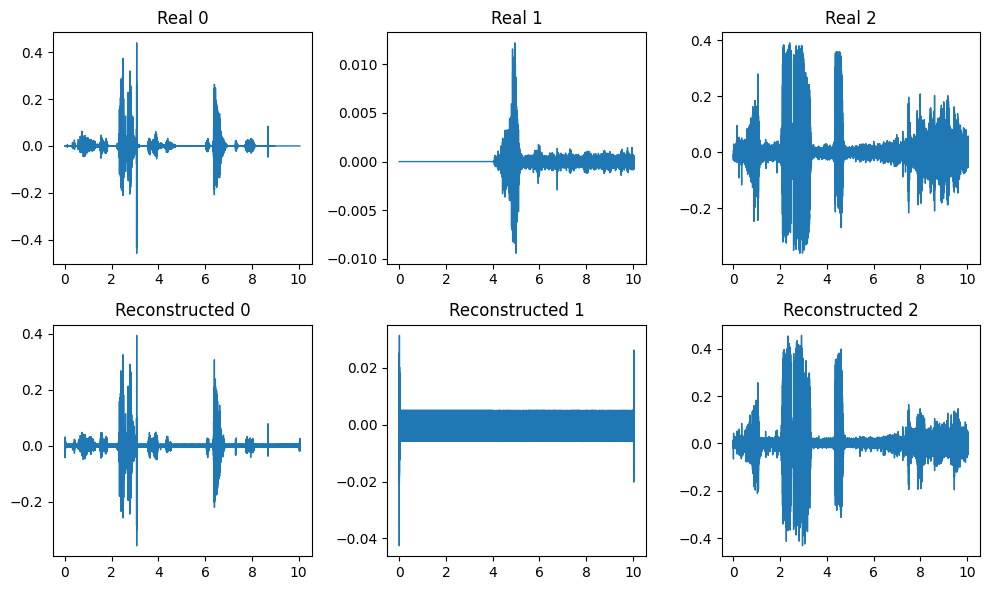

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(10,6))
for i in range(3):
    plot_waveform(work_data[i].detach().cpu().numpy(), ax=ax[0, i])
    ax[0, i].set_title('Real '+str(i))
#     ax[0, i].axis('off')
    
    plot_waveform(reconstructions[i].detach().cpu().numpy(), ax=ax[1, i])
#             ax[1, i].imshow(y_demo[i].permute(1, 2, 0).numpy())
    ax[1, i].set_title('Reconstructed '+str(i))
#     ax[1, i].axis('off')

    plt.tight_layout()

plt.tight_layout()

In [35]:
import IPython
IPython.display.display

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

In [36]:
IPython.display.display(Audio(work_data[0].detach().cpu().numpy(), rate=4000))
IPython.display.display(Audio(reconstructions[0].detach().cpu().numpy(), rate=4000))

In [37]:
IPython.display.display(Audio(work_data[1].detach().cpu().numpy(), rate=4000))
IPython.display.display(Audio(reconstructions[1].detach().cpu().numpy(), rate=4000))

In [38]:
IPython.display.display(Audio(work_data[2].detach().cpu().numpy(), rate=4000))
IPython.display.display(Audio(reconstructions[2].detach().cpu().numpy(), rate=4000))

In [39]:
IPython.display.display(Audio(work_data[13].detach().cpu().numpy(), rate=4000))
IPython.display.display(Audio(reconstructions[13].detach().cpu().numpy(), rate=4000))

In [40]:
torch.save(history, '/kaggle/working/hyst.txt')